# ArchBuddy: Complete Project Notebook

This notebook contains the entire source code of the ArchBuddy project, organized by component. 
Run the cells in order to initialize the system.

In [2]:
# Universal Imports
import logging
import sys
import os
import time
import hashlib
from typing import List, Dict, Any, Optional, TypedDict, Annotated, Literal, cast, Generator
from operator import add
from pydantic import BaseModel, Field

# LangChain Imports
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI
from langchain_community.utilities import GoogleSerperAPIWrapper
# from langchain_chroma import Chroma
from langchain_community.vectorstores import Chroma
from langchain_ollama.embeddings import OllamaEmbeddings
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

# Setup Logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    force=True
)
logger = logging.getLogger(__name__)

## 1. Core Types (`core/types.py`)

In [3]:
def merge_dicts(left: Dict[str, Any], right: Dict[str, Any]) -> Dict[str, Any]:
    """
    Deep merge two dictionaries.
    Used when multiple nodes update nested structures.
    """
    result = left.copy()
    for key, value in right.items():
        if key in result and isinstance(result[key], dict) and isinstance(value, dict):
            result[key] = merge_dicts(result[key], value)
        else:
            result[key] = value
    return result

def last_value(left: Any, right: Any) -> Any:
    """Simple 'last one wins' reducer."""
    return right

class ArchitectureState(TypedDict):
    """
    The complete state for architecture generation.
    """
    # ========== METADATA ==========
    messages: Annotated[List, add]
    user_problem: Annotated[str, last_value]
    iteration_count: Annotated[int, last_value]
    min_iterations: Annotated[int, last_value]
    max_iterations: Annotated[int, last_value]
    
    # ========== GENERATION PHASE ==========
    architecture_domain_tasks: Annotated[Dict[str, Dict[str, Any]], merge_dicts]
    architecture_components: Annotated[Dict[str, Dict[str, Any]], merge_dicts]
    proposed_architecture: Annotated[Dict[str, Any], merge_dicts]
    
    # ========== VALIDATION PHASE ==========
    validation_feedback: Annotated[List[Dict[str, Any]], add]
    validation_summary: Annotated[Optional[str], last_value]
    
    # ========== DECISION ==========
    has_validation_errors: Annotated[bool, lambda a, b: b]
    
    # ========== FINAL OUTPUT ==========
    final_architecture: Annotated[Optional[Dict[str, Any]], last_value]
    architecture_summary: Annotated[Optional[str], last_value]

def create_initial_state(
    user_problem: str,
    min_iterations: int = 2,
    max_iterations: int = 3
) -> ArchitectureState:
    """Create the initial state for a new architecture generation run."""
    return {
        "messages": [HumanMessage(content=user_problem)],
        "user_problem": user_problem,
        "iteration_count": 0,
        "min_iterations": min_iterations,
        "max_iterations": max_iterations,
        "architecture_domain_tasks": {},
        "architecture_components": {},
        "proposed_architecture": {},
        "validation_feedback": [],
        "validation_summary": None,
        "has_validation_errors": False,
        "final_architecture": None,
        "architecture_summary": None
    }

## 2. Schemas (`core/schemas.py`)

In [4]:
class DomainTask(BaseModel):
    """A single task for one domain architect."""
    domain: str = Field(description="Domain name: compute, network, storage, or database")
    task_description: str = Field(description="What should this domain architect do?")
    requirements: List[str] = Field(description="Key requirements for this domain")
    deliverables: List[str] = Field(description="What should the architect produce?")

class TaskDecomposition(BaseModel):
    """Complete task decomposition from supervisor."""
    user_problem: str
    decomposed_tasks: List[DomainTask]
    overall_architecture_goals: List[str]
    constraints: List[str]

class ValidationTask(BaseModel):
    """A validation task for one domain validator."""
    domain: str
    components_to_validate: List[str]
    validation_focus: str

class ValidationDecomposition(BaseModel):
    """Validation tasks from validator supervisor."""
    validation_tasks: List[ValidationTask]

## 3. Tools (`core/tools.py`)

In [5]:
class ToolManager:
    """Centralized tool management."""
    
    def __init__(self):
        self.web_search_tool = self._init_web_search()
        self.rag_tool = self._init_rag()
    
    def _init_web_search(self) -> Tool:
        """Initialize Google Serper for internet search."""
        try:
            serper = GoogleSerperAPIWrapper()
            return Tool(
                name="web_search",
                func=serper.run,
                description="Search the internet for current information about AWS services and best practices"
            )
        except Exception as e:
             # Fallback if Serper not configured
             return Tool(
                name="web_search",
                func=lambda x: "Web search unavailable (check API key)",
                description="Search the internet"
            )
    
    def _init_rag(self) -> Tool:
        """Initialize RAG search for vector database."""
        try:
            embeddings = OllamaEmbeddings(model="nomic-embed-text")
            # Note: Path adjusted for notebook execution context
            db_path = "../chroma_db_AWSDocs" if os.path.exists("../chroma_db_AWSDocs") else "./chroma_db_AWSDocs"
            
            vector_store = Chroma(
                collection_name="AWSDocs",
                persist_directory=db_path,
                embedding_function=embeddings,
            )
            
            def rag_search(query: str, k: int = 5) -> str:
                try:
                    docs = vector_store.similarity_search(query, k=k)
                    if not docs:
                         return "No relevant documentation found."
                    results = []
                    for i, doc in enumerate(docs, 1):
                        content = doc.page_content.strip()[:1000]
                        results.append(f"[Document {i}]:\n{content}\n")
                    return "\n---\n".join(results)
                except Exception as e:
                    logging.error(f"RAG error: {str(e)}")
                    return f"Error: {str(e)}"
            
            return Tool(
                name="RAG_search",
                func=rag_search,
                description="Search AWS documentation for accurate architectural guidance and best practices"
            )
        except Exception as e:
            return Tool(
                name="RAG_search",
                func=lambda x: "RAG unavailable",
                description="Search AWS documentation"
            )
    
    def get_all_tools(self) -> Dict[str, Tool]:
        return {
            self.web_search_tool.name: self.web_search_tool,
            self.rag_tool.name: self.rag_tool,
        }

class LLMManager:
    """Manage LLM instances."""
    
    def __init__(self):
        self.mini_llm = ChatOpenAI(model="gpt-4o-mini")
        self.reasoning_llm = ChatOpenAI(model="gpt-4o")
    
    def get_mini_llm(self):
        return self.mini_llm
    
    def get_reasoning_llm(self):
        return self.reasoning_llm
    
    def get_mini_with_tools(self, tools: list):
        return self.mini_llm.bind_tools(tools)
    
    def get_reasoning_structured(self, schema):
        return self.reasoning_llm.with_structured_output(schema)

## 4. Execution Logic (`core/execution.py`)

In [6]:
def execute_tool_calls(
    messages: List,
    llm_with_tools,
    tools: Dict[str, Tool],
    max_iterations: int = 3,
    timeout: Optional[float] = 60.0,
    retry_attempts: int = 2
) -> AIMessage:
    """Execute LLM with tool calling loop."""
    
    tool_iterations = 0
    final_response = None
    start_time = time.time()
    
    while tool_iterations < max_iterations:
        if timeout and (time.time() - start_time) > timeout:
            logger.warning(f"Timeout after {timeout}s")
            break
        
        response = None
        for attempt in range(retry_attempts + 1):
            try:
                response = llm_with_tools.invoke(messages)
                break
            except Exception as e:
                if attempt < retry_attempts:
                    time.sleep(2 ** attempt)
                else:
                    return AIMessage(content=f"Error: {str(e)}")
        
        if not response or not hasattr(response, "content"):
            break
        
        if hasattr(response, "tool_calls") and response.tool_calls:
            messages.append(response)
            for tool_call in response.tool_calls:
                tool_name = tool_call["name"]
                if tool_name in tools:
                    try:
                        tool_args = tool_call.get("args", {})
                        if not isinstance(tool_args, dict):
                            tool_args = {"query": str(tool_args)}
                        tool_result = tools[tool_name].invoke(tool_args)
                        messages.append(ToolMessage(
                            content=str(tool_result),
                            tool_call_id=tool_call["id"]
                        ))
                    except Exception as e:
                        messages.append(ToolMessage(
                            content=f"Error: {str(e)}",
                            tool_call_id=tool_call["id"]
                        ))
                else:
                    messages.append(ToolMessage(
                        content=f"Unknown tool: {tool_name}",
                        tool_call_id=tool_call["id"]
                    ))
            tool_iterations += 1
        else:
            final_response = response
            break
            
    if final_response is None:
        for msg in reversed(messages):
            if isinstance(msg, AIMessage):
                final_response = msg
                break
        if final_response is None:
            final_response = AIMessage(content="Tool execution incomplete")
            
    return final_response

def detect_errors_llm(validation_result: str) -> bool:
    """Use LLM to detect if validation found errors."""
    try:
        # Start a local manager for this util
        llm_manager = LLMManager()
        mini_llm = llm_manager.get_mini_llm()
        
        max_length = 1000
        truncated = validation_result[:1000] if len(validation_result) > 1000 else validation_result
        
        error_detection_prompt = f"""
Analyze this validation result and determine if it indicates any errors or issues.
Validation Result:
{truncated}
Respond with ONLY the word "YES" if there are errors, or ONLY the word "NO" if everything is valid.
"""
        response = mini_llm.invoke([SystemMessage(content=error_detection_prompt)])
        result_text = getattr(response, "content", "").strip().upper()
        
        if result_text.startswith("YES"):
            return True
        elif result_text.startswith("NO"):
            return False
        else:
            strong_indicators = ["error", "incorrect", "invalid", "misconfiguration"]
            return any(kw in validation_result.lower() for kw in strong_indicators)
    except Exception as e:
        return True

## 5. Architects (`nodes/architects.py`)

In [7]:
def format_component_recommendations(domain_name: str, task_info: Dict[str, Any], generated_text: Optional[str]) -> str:
    if generated_text and generated_text.strip():
        return generated_text.strip()
    return f"*(Generated content unavailable for {domain_name})*"

def generic_domain_architect(state: ArchitectureState, domain: str, domain_services: str, llm_manager, tool_manager, timeout: float = 120.0) -> ArchitectureState:
    node_name = f"{domain}_architect"
    logger.info(f"--- {domain.capitalize()} Architect ---")
    start_time = time.time()
    try:
        domain_task = state["architecture_domain_tasks"].get(domain, {})
        if not domain_task:
            return {"architecture_components": {domain: {"recommendations": "No task", "error": "No task"}}}
        
        validation_feedback = state.get("validation_feedback", [])
        domain_feedback = [fb for fb in validation_feedback if isinstance(fb, dict) and fb.get("domain", "").lower() == domain.lower()]
        feedback_context = ""
        if domain_feedback:
            feedback_context = "\n\n**Issues Found in Previous Validation:**\n" + "\n".join([f"- {fb.get('result', '')[:200]}" for fb in domain_feedback])
        
        system_prompt = f"""
You are an AWS {domain.capitalize()} Domain Architect.
Your expertise: {domain_services}
**Problem**: {state["user_problem"]}
**Task**: {domain_task.get('task_description', 'Design infrastructure')}
**Requirements**: {', '.join(domain_task.get('requirements', []))}
{feedback_context}
Design detailed {domain} infrastructure. Use web_search or RAG_search if needed.
"""
        local_messages = [SystemMessage(content=system_prompt), HumanMessage(content=state["user_problem"])]
        tools_dict = tool_manager.get_all_tools()
        llm_with_tools = llm_manager.get_mini_with_tools(list(tools_dict.values()))
        
        final_response = execute_tool_calls(local_messages, llm_with_tools, tools_dict, timeout=timeout)
        content = getattr(final_response, "content", "")
        recommendations = format_component_recommendations(domain, domain_task, content)
        
        return {"architecture_components": {domain: {"recommendations": recommendations, "domain": domain, "task_info": domain_task}}}
    except Exception as e:
        logger.error(f"{domain} architect error: {e}")
        return {"architecture_components": {domain: {"recommendations": f"Error: {e}", "error": str(e)}}}

def compute_architect(state: ArchitectureState, llm_manager, tool_manager) -> ArchitectureState:
    return generic_domain_architect(state, "compute", "EC2, Lambda, ECS, EKS", llm_manager, tool_manager)

def network_architect(state: ArchitectureState, llm_manager, tool_manager) -> ArchitectureState:
    return generic_domain_architect(state, "network", "VPC, ALB, Route 53", llm_manager, tool_manager)

def storage_architect(state: ArchitectureState, llm_manager, tool_manager) -> ArchitectureState:
    return generic_domain_architect(state, "storage", "S3, EBS, EFS", llm_manager, tool_manager)

def database_architect(state: ArchitectureState, llm_manager, tool_manager) -> ArchitectureState:
    return generic_domain_architect(state, "database", "RDS, DynamoDB, ElastiCache", llm_manager, tool_manager)

## 6. Validators (`nodes/validators.py`)

In [8]:
def get_services_for_domain(domain: str) -> List[str]:
    return {
        "compute": ["EC2", "Lambda", "ECS"],
        "network": ["VPC", "Security Groups", "ALB"],
        "storage": ["S3", "EBS"],
        "database": ["RDS", "DynamoDB"]
    }.get(domain, [])

def get_validation_focus(domain: str) -> str:
    return {
        "compute": "Sizing, scaling, cost",
        "network": "Security, routing",
        "storage": "Access control, encryption",
        "database": "HA, backups"
    }.get(domain, "general validation")

def validator_supervisor(state: ArchitectureState, llm_manager) -> ArchitectureState:
    logger.info("--- Validator Supervisor ---")
    try:
        comps = state.get("architecture_components", {})
        val_tasks = {}
        for domain in comps.keys():
            val_tasks[domain] = {
                "components_to_validate": get_services_for_domain(domain),
                "validation_focus": get_validation_focus(domain)
            }
        
        # Simple merge mimic since we are in one file
        prev = state.get("architecture_domain_tasks", {})
        merged = prev.copy()
        merged["validation_tasks"] = val_tasks
        return {"architecture_domain_tasks": merged}
    except Exception as e:
        return {"architecture_domain_tasks": state.get("architecture_domain_tasks", {})}

def generic_domain_validator(state: ArchitectureState, domain: str, llm_manager, tool_manager, timeout: float = 60.0) -> ArchitectureState:
    logger.info(f"--- {domain.capitalize()} Validator ---")
    try:
        recs = state.get("architecture_components", {}).get(domain, {}).get("recommendations", "")
        if not recs:
             return {"validation_feedback": [{"domain": domain, "status": "skipped", "has_errors": False}]}

        system_prompt = f"""
Validate aws architecture.
Domain: {domain}
Focus: {get_validation_focus(domain)}
Recommendation: {recs}
Check for errors. Report issues.
"""
        tools = tool_manager.get_all_tools()
        rag_only = {"RAG_search": tools.get("RAG_search", tools["web_search"])}
        llm = llm_manager.get_mini_with_tools(list(rag_only.values()))
        response = execute_tool_calls([SystemMessage(content=system_prompt)], llm, rag_only, timeout=timeout)
        
        val_result = getattr(response, "content", "Validation done")
        has_errors = detect_errors_llm(val_result)
        return {"validation_feedback": [{"domain": domain, "result": val_result, "has_errors": has_errors}], "has_validation_errors": has_errors}
    except Exception as e:
        return {"validation_feedback": [{"domain": domain, "result": f"Error: {e}", "has_errors": True}], "has_validation_errors": True}

def compute_validator(state, llm, tools): return generic_domain_validator(state, "compute", llm, tools)
def network_validator(state, llm, tools): return generic_domain_validator(state, "network", llm, tools)
def storage_validator(state, llm, tools): return generic_domain_validator(state, "storage", llm, tools)
def database_validator(state, llm, tools): return generic_domain_validator(state, "database", llm, tools)

def validation_synthesizer(state: ArchitectureState, llm_manager) -> ArchitectureState:
    logger.info("--- Validation Synthesizer ---")
    try:
        all_fb = state.get("validation_feedback", [])
        if not all_fb: return {"has_validation_errors": False}
        
        error_count = sum(1 for fb in all_fb if fb.get("has_errors"))
        fb_text = "\n".join([f"{fb['domain']}: {fb['result'][:200]}" for fb in all_fb])
        
        system_prompt = f"Summarize validation results:\n{fb_text}\nErrors: {error_count}"
        response = llm_manager.get_reasoning_llm().invoke([SystemMessage(content=system_prompt)])
        return {"validation_summary": getattr(response, "content", ""), "has_validation_errors": error_count > 0}
    except Exception as e:
        return {"validation_summary": str(e), "has_validation_errors": True}

## 7. Synthesizer & Supervisor (`nodes/synthesizer.py`, `nodes/supervisor.py`)

In [9]:
def architect_synthesizer(state: ArchitectureState, llm_manager) -> ArchitectureState:
    logger.info("--- Architect Synthesizer ---")
    try:
        comps = state.get("architecture_components", {})
        if not comps:
             return {"proposed_architecture": {"architecture_summary": "No components"}}
        
        summaries = []
        for d, i in comps.items():
            summaries.append(f"**{d.upper()}**: {i.get('recommendations', 'N/A')}")
            
        system_prompt = f"""
Synthesize these components into one architecture:
{''.join(summaries)}
Problem: {state['user_problem']}
"""
        response = llm_manager.get_reasoning_llm().invoke([SystemMessage(content=system_prompt)])
        return {"proposed_architecture": {"architecture_summary": response.content, "source_components": comps}}
    except Exception as e:
        return {"proposed_architecture": {"architecture_summary": f"Error: {e}"}}

def architect_supervisor(state: ArchitectureState, llm_manager, max_retries: int = 3) -> ArchitectureState:
    logger.info("--- Architect Supervisor ---")
    try:
        system_prompt = f"""
Break down problem into tasks for Compute, Network, Storage, Database.
Problem: {state['user_problem']}
"""
        structured = llm_manager.get_reasoning_structured(TaskDecomposition)
        response = structured.invoke([SystemMessage(content=system_prompt)])
        
        updates = {"overall_goals": response.overall_architecture_goals, "constraints": response.constraints}
        for t in response.decomposed_tasks:
            updates[t.domain.lower()] = {"task_description": t.task_description, "requirements": t.requirements, "deliverables": t.deliverables}
            
        return {
            "architecture_domain_tasks": updates,
            "iteration_count": state["iteration_count"] + 1,
            "validation_feedback": [],
            "architecture_components": {},
            "has_validation_errors": False
        }
    except Exception as e:
        logger.error(f"Supervisor failed: {e}")
        return {"iteration_count": state["iteration_count"] + 1, "has_validation_errors": True}

## 8. Iteration & Graph (`nodes/iteration.py`, `graph/builder.py`)

In [10]:
def iteration_condition(state: ArchitectureState) -> Literal["iterate", "finish"]:
    itr = state.get("iteration_count", 0)
    min_i = state.get("min_iterations", 1)
    max_i = state.get("max_iterations", 3)
    err = state.get("has_validation_errors", False)
    
    if itr < min_i: return "iterate"
    if err and itr < max_i: return "iterate"
    return "finish"

def final_architecture_generator(state: ArchitectureState, llm_manager) -> ArchitectureState:
    logger.info("--- Final Generator ---")
    try:
        summary = state.get("proposed_architecture", {}).get("architecture_summary", "")
        response = llm_manager.get_reasoning_llm().invoke([SystemMessage(content=f"Create final doc based on: {summary}")])
        return {"final_architecture": {"document": response.content}}
    except Exception as e:
        return {"final_architecture": {"document": str(e)}}

def build_architecture_graph(llm_manager, tool_manager):
    logger.info("Building Graph...")
    builder = StateGraph(ArchitectureState)
    
    builder.add_node("architect_supervisor", lambda s: architect_supervisor(s, llm_manager))
    builder.add_node("compute_architect", lambda s: compute_architect(s, llm_manager, tool_manager))
    builder.add_node("network_architect", lambda s: network_architect(s, llm_manager, tool_manager))
    builder.add_node("storage_architect", lambda s: storage_architect(s, llm_manager, tool_manager))
    builder.add_node("database_architect", lambda s: database_architect(s, llm_manager, tool_manager))
    builder.add_node("architect_synthesizer", lambda s: architect_synthesizer(s, llm_manager))
    builder.add_node("validator_supervisor", lambda s: validator_supervisor(s, llm_manager))
    builder.add_node("compute_validator", lambda s: compute_validator(s, llm_manager, tool_manager))
    builder.add_node("network_validator", lambda s: network_validator(s, llm_manager, tool_manager))
    builder.add_node("storage_validator", lambda s: storage_validator(s, llm_manager, tool_manager))
    builder.add_node("database_validator", lambda s: database_validator(s, llm_manager, tool_manager))
    builder.add_node("validation_synthesizer", lambda s: validation_synthesizer(s, llm_manager))
    builder.add_node("final_architecture_generator", lambda s: final_architecture_generator(s, llm_manager))
    
    builder.add_edge(START, "architect_supervisor")
    builder.add_edge("architect_supervisor", "compute_architect")
    builder.add_edge("architect_supervisor", "network_architect")
    builder.add_edge("architect_supervisor", "storage_architect")
    builder.add_edge("architect_supervisor", "database_architect")
    builder.add_edge("compute_architect", "architect_synthesizer")
    builder.add_edge("network_architect", "architect_synthesizer")
    builder.add_edge("storage_architect", "architect_synthesizer")
    builder.add_edge("database_architect", "architect_synthesizer")
    builder.add_edge("architect_synthesizer", "validator_supervisor")
    builder.add_edge("validator_supervisor", "compute_validator")
    builder.add_edge("validator_supervisor", "network_validator")
    builder.add_edge("validator_supervisor", "storage_validator")
    builder.add_edge("validator_supervisor", "database_validator")
    builder.add_edge("compute_validator", "validation_synthesizer")
    builder.add_edge("network_validator", "validation_synthesizer")
    builder.add_edge("storage_validator", "validation_synthesizer")
    builder.add_edge("database_validator", "validation_synthesizer")
    
    builder.add_conditional_edges(
        "validation_synthesizer",
        iteration_condition,
        {"iterate": "architect_supervisor", "finish": "final_architecture_generator"}
    )
    builder.add_edge("final_architecture_generator", END)
    
    return builder.compile(checkpointer=MemorySaver())

## 9. Main System (`main.py`)

In [11]:
class ArchitectureGenerationSystem:
    def __init__(self):
        logger.info("Initializing System...")
        self.tool_manager = ToolManager()
        self.llm_manager = LLMManager()
        self.graph = build_architecture_graph(self.llm_manager, self.tool_manager)
    
    def run(self, user_problem, thread_id=None, min_iterations=1, max_iterations=2):
        if thread_id is None: thread_id = f"arch-{int(time.time())}"
        config = {"configurable": {"thread_id": thread_id}}
        
        state = create_initial_state(user_problem, min_iterations, max_iterations)
        logger.info(f"Starting run {thread_id}...")
        return self.graph.invoke(state, config=config)

In [12]:
logger.info("Building Graph...")
builder = StateGraph(ArchitectureState)

builder.add_node("architect_supervisor", lambda s: architect_supervisor(s, llm_manager))
builder.add_node("compute_architect", lambda s: compute_architect(s, llm_manager, tool_manager))
builder.add_node("network_architect", lambda s: network_architect(s, llm_manager, tool_manager))
builder.add_node("storage_architect", lambda s: storage_architect(s, llm_manager, tool_manager))
builder.add_node("database_architect", lambda s: database_architect(s, llm_manager, tool_manager))
builder.add_node("architect_synthesizer", lambda s: architect_synthesizer(s, llm_manager))
builder.add_node("validator_supervisor", lambda s: validator_supervisor(s, llm_manager))
builder.add_node("compute_validator", lambda s: compute_validator(s, llm_manager, tool_manager))
builder.add_node("network_validator", lambda s: network_validator(s, llm_manager, tool_manager))
builder.add_node("storage_validator", lambda s: storage_validator(s, llm_manager, tool_manager))
builder.add_node("database_validator", lambda s: database_validator(s, llm_manager, tool_manager))
builder.add_node("validation_synthesizer", lambda s: validation_synthesizer(s, llm_manager))
builder.add_node("final_architecture_generator", lambda s: final_architecture_generator(s, llm_manager))

builder.add_edge(START, "architect_supervisor")
builder.add_edge("architect_supervisor", "compute_architect")
builder.add_edge("architect_supervisor", "network_architect")
builder.add_edge("architect_supervisor", "storage_architect")
builder.add_edge("architect_supervisor", "database_architect")
builder.add_edge("compute_architect", "architect_synthesizer")
builder.add_edge("network_architect", "architect_synthesizer")
builder.add_edge("storage_architect", "architect_synthesizer")
builder.add_edge("database_architect", "architect_synthesizer")
builder.add_edge("architect_synthesizer", "validator_supervisor")
builder.add_edge("validator_supervisor", "compute_validator")
builder.add_edge("validator_supervisor", "network_validator")
builder.add_edge("validator_supervisor", "storage_validator")
builder.add_edge("validator_supervisor", "database_validator")
builder.add_edge("compute_validator", "validation_synthesizer")
builder.add_edge("network_validator", "validation_synthesizer")
builder.add_edge("storage_validator", "validation_synthesizer")
builder.add_edge("database_validator", "validation_synthesizer")

builder.add_conditional_edges(
    "validation_synthesizer",
    iteration_condition,
    {"iterate": "architect_supervisor", "finish": "final_architecture_generator"}
)
builder.add_edge("final_architecture_generator", END)

2026-02-07 19:58:31,535 - __main__ - INFO - Building Graph...


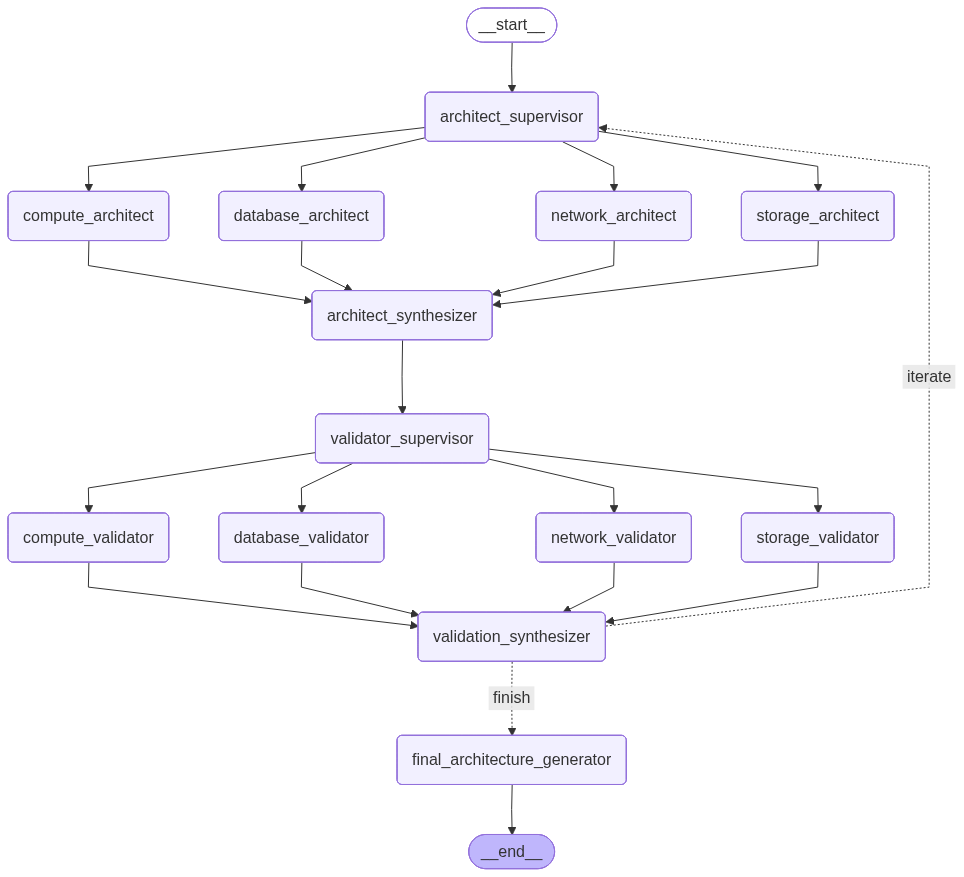

In [14]:
graph = builder.compile()
graph

## 10. Run It

In [ ]:
from dotenv import load_dotenv
load_dotenv()

# Ensure you have OPENAI_API_KEY set in your .env or environment
system = ArchitectureGenerationSystem()

result = system.run(
    user_problem="Build a highly available e-commerce platform on AWS",
    thread_id="notebook-run-1",
    min_iterations=1,
    max_iterations=1  # Keeping it short for testing
)

print("\n--- FINAL DOCUMENT ---\n")
print(result.get("final_architecture", {}).get("document", "No document generated"))